In [2]:
# Importamos las librerias a usar y cargamos el dataset:
import torchvision
import random
from torchvision.datasets import SVHN
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.metrics import accuracy_score
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

trainset = SVHN(root='./data', split='train', download=True)
testset = SVHN(root='./data', split='test', download=True)

classes = tuple(str(i) for i in range(10))  # '0','1',...,'9'

print(len(trainset), len(testset))

100.0%


100.0%


73257 26032


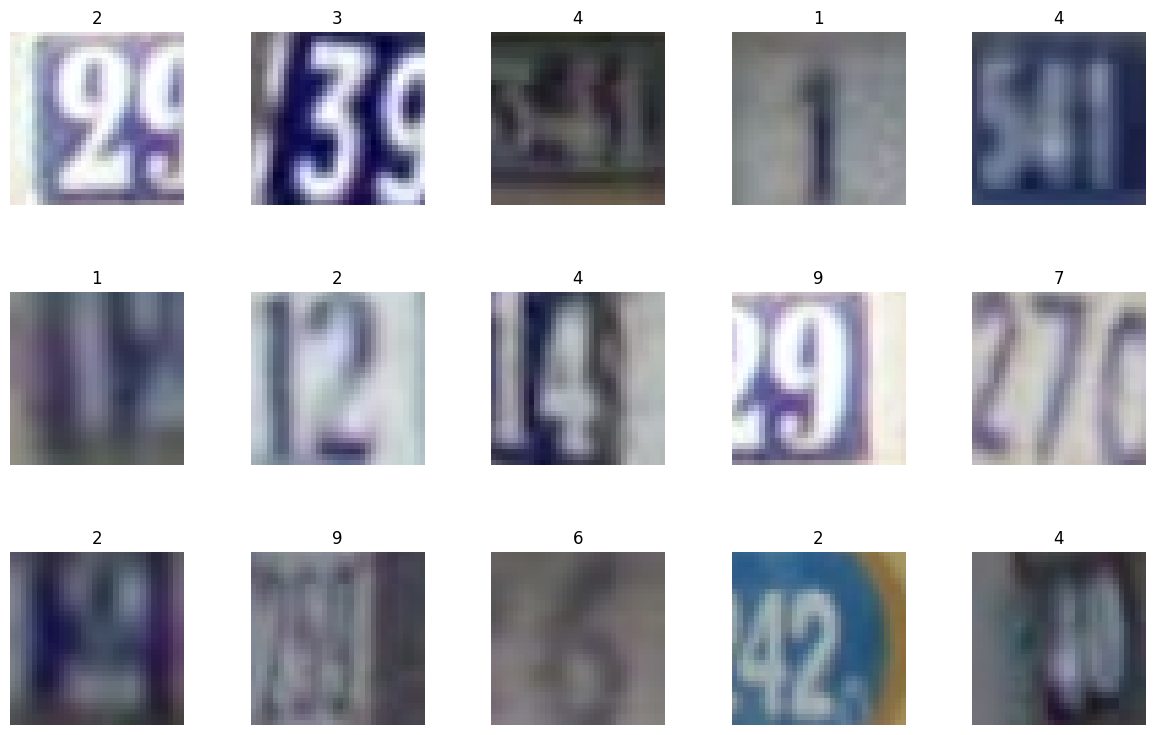

In [3]:
#visualizción imágenes
r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [4]:
# convertimos imágenes a arrays de numpy
train_images = np.array([np.array(img) for img, label in trainset])
test_images = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label if label < 10 else 0 for label in trainset.labels])
test_labels = np.array([label if label < 10 else 0 for label in testset.labels])

# ver número de imágenes, resolución y número de canales
print(train_images.shape, test_images.shape, train_labels.shape, test_labels.shape)

# tipo de datos
print(train_images.dtype, train_labels.dtype)

# Estadísiticos
max_value = train_images.max(axis=(0, 1, 2))
min_value = train_images.min(axis=(0, 1, 2))

print(max_value, min_value)

mean = (train_images / 255).mean(axis=(0, 1, 2))
std = (train_images / 255).std(axis=(0, 1, 2))

print(mean, std)

(73257, 32, 32, 3) (26032, 32, 32, 3) (73257,) (26032,)
uint8 int64
[255 255 255] [0 0 0]
[0.4376821  0.4437697  0.47280442] [0.19803012 0.20101562 0.19703614]


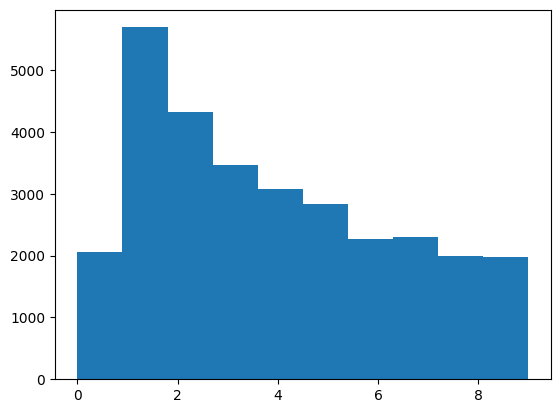

In [5]:
# distribución de clases
plt.hist(train_labels[:30000], bins=len(classes))
plt.show()

## Se observa que hay mas datos de algunas clases, por lo cual no es un dataset tan confiable

In [6]:
# Dividimos los datos para entrenar solo con un subset:

unique, counts = np.unique(train_labels, return_counts=True)
print(unique, counts)

train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images[:40000], train_images[40000:], train_images[:5000]
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:], train_labels[:5000]

print(X_train.shape, X_val.shape, X_test.shape, X_subset.shape)

[0 1 2 3 4 5 6 7 8 9] [ 4948 13861 10585  8497  7458  6882  5727  5595  5045  4659]
(40000, 32, 32, 3) (33257, 32, 32, 3) (26032, 32, 32, 3) (5000, 32, 32, 3)


In [7]:
# Aplicamos la Regularizacion
def build_model(D_in=32*32*3, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

In [8]:
# Definimos las funciones de entrenamiento y softmax

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def fit(model, dataloader, optimizer, scheduler=None, epochs=10, log_each=1, weight_decay=0, early_stopping=0, verbose=1):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1):
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            if verbose == 2:
                print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        if scheduler:
            scheduler.step()
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each and verbose:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

In [9]:
trans = Compose([
    RandomCrop(24,24),
    Resize(32, 32),
    HorizontalFlip(),
    OneOf([
        ToGray(p=0.2),
        RGBShift(p=0.3)
    ])
])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, trans=None):
        self.X = X
        self.Y = Y
        self.trans = trans

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        img = self.X[ix]
        if self.trans:
            img = self.trans(image=img)["image"]  # numpy HxWxC
        img = (img / 255.).astype(np.float32)
        img = torch.from_numpy(img).permute(2,0,1).flatten().cuda()  # vector 3072
        label = torch.tensor(self.Y[ix]).long().cuda()
        return img, label


In [11]:
# Definimos el dataset con el subset para ahorrar computo, pero entendiendo como se usa:
dataset = {
    'train': Dataset(X_subset, y_subset, trans=trans),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 33257)

Mejor modelo guardado con acc 0.18527 en epoch 1
Epoch 1/100 loss 2.24800 acc 0.18295 val_loss 2.33520 val_acc 0.18527 lr 0.00100
Mejor modelo guardado con acc 0.18892 en epoch 2
Epoch 2/100 loss 2.17007 acc 0.22053 val_loss 2.49794 val_acc 0.18892 lr 0.00100
Epoch 3/100 loss 2.13531 acc 0.24110 val_loss 2.28877 val_acc 0.17857 lr 0.00100
Mejor modelo guardado con acc 0.20906 en epoch 4
Epoch 4/100 loss 2.09185 acc 0.27275 val_loss 2.18703 val_acc 0.20906 lr 0.00100
Mejor modelo guardado con acc 0.21667 en epoch 5
Epoch 5/100 loss 2.05808 acc 0.28184 val_loss 2.22451 val_acc 0.21667 lr 0.00100
Epoch 6/100 loss 2.01475 acc 0.29905 val_loss 2.22479 val_acc 0.19979 lr 0.00100
Epoch 7/100 loss 1.96984 acc 0.31606 val_loss 2.26439 val_acc 0.19276 lr 0.00100
Mejor modelo guardado con acc 0.24613 en epoch 8
Epoch 8/100 loss 1.95058 acc 0.32456 val_loss 2.14373 val_acc 0.24613 lr 0.00100
Mejor modelo guardado con acc 0.28414 en epoch 9
Epoch 9/100 loss 1.90495 acc 0.33999 val_loss 2.06673 val_

C:\Users\picas\AppData\Local\Temp\ipykernel_6976\1116800428.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpt.pt'))


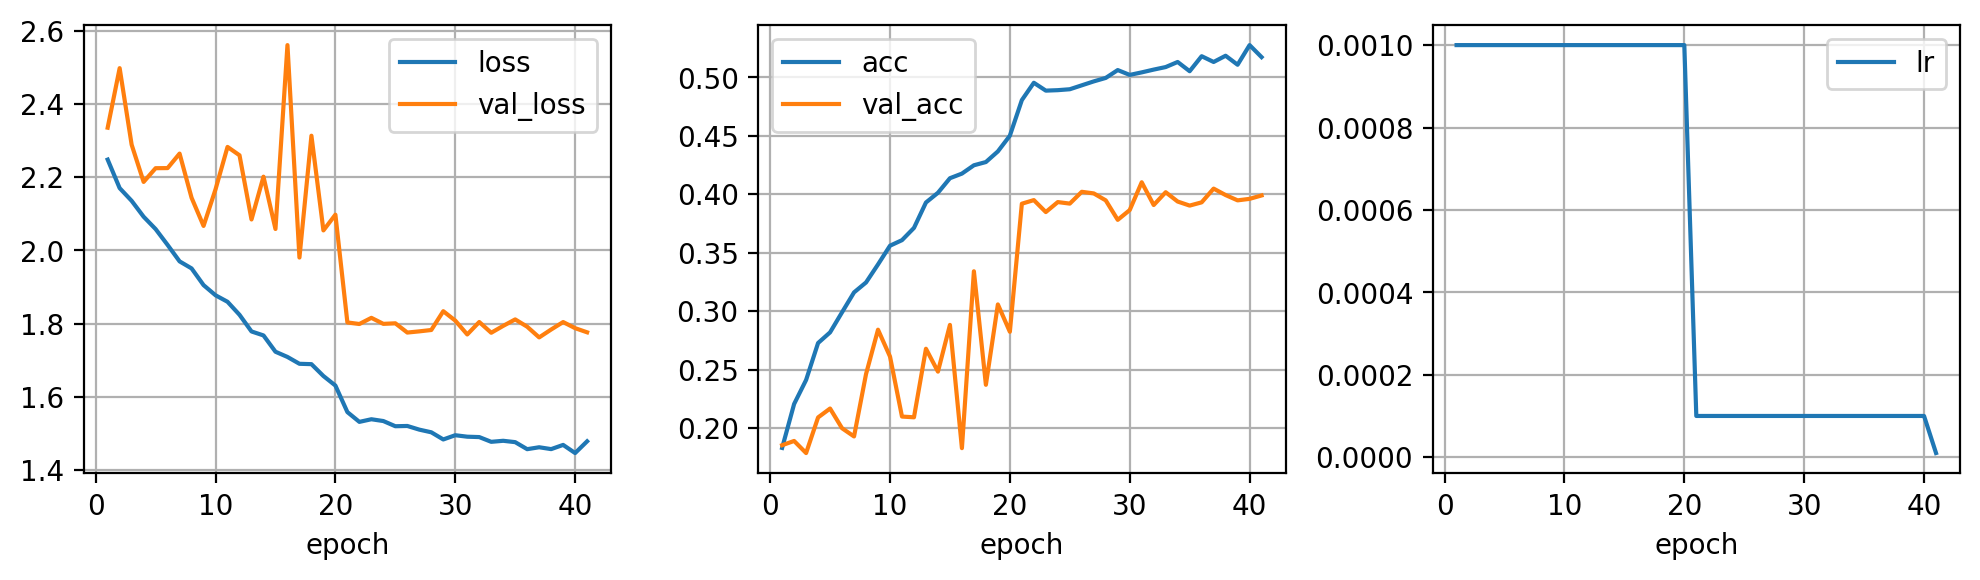

In [12]:
# Entrenamos aplicando Adam como optimizador y un scheduler para el learning rate mas efectivo:

model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.1)
hist = fit(model, dataloader, optimizer, scheduler, epochs=100, early_stopping=10, verbose=2)

# Luego mostramos la grafica para comprobar que el entrenamiento se hizo bien
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(131)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(132)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
ax = plt.subplot(133)
pd.DataFrame(hist).plot(x='epoch', y=['lr'], grid=True, ax=ax)
plt.tight_layout()
plt.show()

Las graficas muestran que tanto la regularizacion como los optimizadores dieron buenos resultados en un subset, con el dataset completo tendriamos muchos mejores resultados.